<a href="https://colab.research.google.com/github/adriancaetanoeste/Analisis-Netflix-Python/blob/main/ProyectoParteFINAL%2BCaetano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Celda 1: Importación de Librerías ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression # Opcional, como comparación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

print("Librerías importadas.")

Librerías importadas.


In [2]:
# --- Celda 2: Cargar y Preparar Datos Iniciales ---
# Asegúrate de que 'netflix_titles.csv' esté subido a tu sesión de Colab
df = pd.read_csv('netflix_titles.csv')
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")

# Limpieza de 'date_added'
df.dropna(subset=['date_added'], inplace=True)
df['date_added'] = df['date_added'].str.strip()
df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', errors='coerce')
df.dropna(subset=['date_added'], inplace=True) # Eliminar si hubo error en conversión
df['year_added'] = df['date_added'].dt.year.astype(int)

# Manejar otros nulos
df['rating'].fillna(df['rating'].mode()[0], inplace=True)
df['country'].fillna('Unknown', inplace=True)
df.dropna(subset=['duration'], inplace=True) # Eliminar filas con duration nulo

# Ingeniería simple de características
df['country'] = df['country'].apply(lambda x: x.split(',')[0].strip())
df['listed_in'] = df['listed_in'].apply(lambda x: x.split(',')[0].strip())

print("\nLimpieza inicial completada. Primeras 5 filas:")
print(df.head())
print("\nInformación del DataFrame después de limpieza:")
df.info()

Dataset cargado con 8807 filas y 12 columnas.

Limpieza inicial completada. Primeras 5 filas:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        Unknown   
3                                                NaN        Unknown   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

  date_added  release_year rating   duration               listed_in  \
0 2021-09-25          2020  PG-13 

In [3]:
# --- Celda 3: Definir Features (X) y Target (y) ---
features = ['release_year', 'year_added', 'rating', 'country', 'listed_in']
target = 'type'

X = df[features]
y = df[target].apply(lambda x: 1 if x == 'TV Show' else 0) # 1 para TV Show, 0 para Movie

print("\nFeatures (X) seleccionadas:")
print(X.head())
print("\nTarget (y) convertida (0=Movie, 1=TV Show):")
print(y.head())
print(f"\nDimensiones: X={X.shape}, y={y.shape}")


Features (X) seleccionadas:
   release_year  year_added rating        country               listed_in
0          2020        2021  PG-13  United States           Documentaries
1          2021        2021  TV-MA   South Africa  International TV Shows
2          2021        2021  TV-MA        Unknown          Crime TV Shows
3          2021        2021  TV-MA        Unknown              Docuseries
4          2021        2021  TV-MA          India  International TV Shows

Target (y) convertida (0=Movie, 1=TV Show):
0    0
1    1
2    1
3    1
4    1
Name: type, dtype: int64

Dimensiones: X=(8794, 5), y=(8794,)


In [4]:
# --- Celda 4: Dividir Datos (Entrenamiento y Prueba) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Datos divididos en entrenamiento y prueba:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Datos divididos en entrenamiento y prueba:
X_train: (7035, 5), X_test: (1759, 5)
y_train: (7035,), y_test: (1759,)


In [5]:
# --- Celda 5: Preprocesamiento (OneHotEncoder para categóricas) ---
categorical_features = ['rating', 'country', 'listed_in']
numerical_features = ['release_year', 'year_added']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', encoder, categorical_features)
    ],
    remainder='drop'
)

# Ajustar y transformar datos de entrenamiento
X_train_processed = preprocessor.fit_transform(X_train)
print(f"X_train procesado. Nuevas dimensiones: {X_train_processed.shape}")

# Transformar datos de prueba (usando el preprocesador ya ajustado)
X_test_processed = preprocessor.transform(X_test)
print(f"X_test procesado. Nuevas dimensiones: {X_test_processed.shape}")

# Guardar los nombres de las nuevas features (útil para después)
feature_names_out = preprocessor.get_feature_names_out()
print(f"\nSe generaron {len(feature_names_out)} features después del preprocesamiento.")
print("Ejemplo de nombres:", feature_names_out[:5].tolist() + ['...'] + feature_names_out[-5:].tolist())

X_train procesado. Nuevas dimensiones: (7035, 134)
X_test procesado. Nuevas dimensiones: (1759, 134)

Se generaron 134 features después del preprocesamiento.
Ejemplo de nombres: ['num__release_year', 'num__year_added', 'cat__rating_G', 'cat__rating_NC-17', 'cat__rating_NR', '...', 'cat__listed_in_TV Dramas', 'cat__listed_in_TV Horror', 'cat__listed_in_TV Sci-Fi & Fantasy', 'cat__listed_in_TV Shows', 'cat__listed_in_Thrillers']


--- Iniciando Selección de Características ---
Entrenando modelo para calcular importancia de features...
Entrenamiento completado.

--- Top 15 Características Más Importantes ---
                                     feature  importance
114    cat__listed_in_International TV Shows    0.162904
106            cat__listed_in_Crime TV Shows    0.092743
115                  cat__listed_in_Kids' TV    0.081893
110                    cat__listed_in_Dramas    0.064347
101          cat__listed_in_British TV Shows    0.052666
105                  cat__listed_in_Comedies    0.051366
109                cat__listed_in_Docuseries    0.050684
108             cat__listed_in_Documentaries    0.042639
100              cat__listed_in_Anime Series    0.038007
98         cat__listed_in_Action & Adventure    0.033196
102  cat__listed_in_Children & Family Movies    0.033118
0                          num__release_year    0.026263
119                cat__listed_in_Reality TV    0.026120
128               cat_

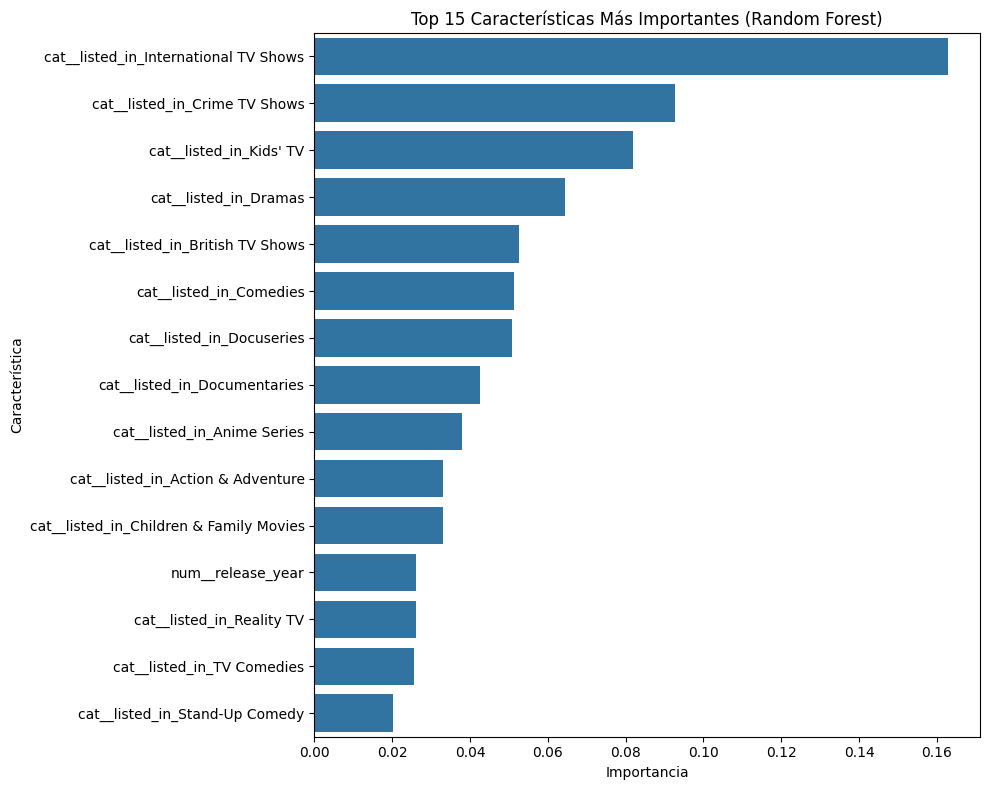


--- Decisión de Selección ---
Basado en las importancias, usaremos todas las características procesadas para el modelo final,
ya que Random Forest maneja bien un número mayor de features.
Las importancias nos sirven principalmente para entender qué datos influyen más en la predicción.


In [6]:
# --- Celda 6: Selección de Características (Usando Importancia de Random Forest) ---

print("--- Iniciando Selección de Características ---")

# Entrenar un RandomForestClassifier inicial para obtener la importancia de las features
# Usamos los datos ya preprocesados (X_train_processed)
rf_for_selection = RandomForestClassifier(n_estimators=100, # Número de árboles
                                          random_state=42,   # Para reproducibilidad
                                          n_jobs=-1)         # Usar todos los procesadores disponibles

print("Entrenando modelo para calcular importancia de features...")
rf_for_selection.fit(X_train_processed, y_train)
print("Entrenamiento completado.")

# Obtener la importancia de cada característica
importances = rf_for_selection.feature_importances_

# Crear un DataFrame para visualizar mejor las importancias
# Usamos los 'feature_names_out' que obtuvimos del preprocesador en la celda 5
feature_importance_df = pd.DataFrame({
    'feature': feature_names_out,
    'importance': importances
}).sort_values('importance', ascending=False) # Ordenar de más a menos importante

# Mostrar las 15 características más importantes
print("\n--- Top 15 Características Más Importantes ---")
print(feature_importance_df.head(15))

# (Opcional pero recomendado) Graficar las importancias para verlo visualmente
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Características Más Importantes (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout() # Ajustar layout para que no se superpongan nombres
plt.show()

print("\n--- Decisión de Selección ---")
print("Basado en las importancias, usaremos todas las características procesadas para el modelo final,")
print("ya que Random Forest maneja bien un número mayor de features.")
print("Las importancias nos sirven principalmente para entender qué datos influyen más en la predicción.")

In [7]:
# --- Celda 7: Entrenamiento del Modelo (Usando Pipeline) ---

print("--- Iniciando Entrenamiento de Modelos ---")

# Crear el Pipeline para Random Forest
# Combina el preprocesador (definido en Celda 5) y el clasificador
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Paso 1: Aplicar preprocesamiento
    ('classifier', RandomForestClassifier(n_estimators=100, # Paso 2: Clasificador
                                          random_state=42,
                                          n_jobs=-1))
])

# Crear el Pipeline para Logistic Regression (Opcional, como baseline)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42,
                                      max_iter=1000)) # Aumentar max_iter por si acaso
])

# Entrenar el Pipeline de Random Forest
# Usamos X_train (datos originales, sin procesar), el pipeline aplica el preprocesador internamente
print("Entrenando Random Forest...")
rf_pipeline.fit(X_train, y_train)
print("Random Forest entrenado.")

# Entrenar el Pipeline de Logistic Regression (Opcional)
print("\nEntrenando Logistic Regression (baseline)...")
lr_pipeline.fit(X_train, y_train)
print("Logistic Regression entrenado.")

print("\n--- Entrenamiento de Modelos Completado ---")

--- Iniciando Entrenamiento de Modelos ---
Entrenando Random Forest...
Random Forest entrenado.

Entrenando Logistic Regression (baseline)...
Logistic Regression entrenado.

--- Entrenamiento de Modelos Completado ---


--- Iniciando Evaluación de Modelos ---

--- Resultados del Random Forest ---
Accuracy Random Forest: 1.0000

Classification Report Random Forest:
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1226
     TV Show       1.00      1.00      1.00       533

    accuracy                           1.00      1759
   macro avg       1.00      1.00      1.00      1759
weighted avg       1.00      1.00      1.00      1759


Confusion Matrix Random Forest:


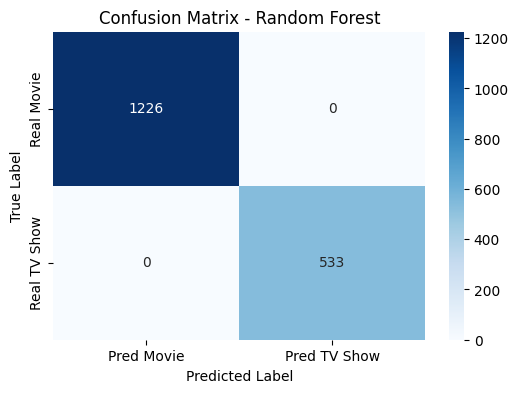



--- Resultados de Logistic Regression (Baseline) ---
Accuracy Logistic Regression: 1.0000

Classification Report Logistic Regression:
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1226
     TV Show       1.00      1.00      1.00       533

    accuracy                           1.00      1759
   macro avg       1.00      1.00      1.00      1759
weighted avg       1.00      1.00      1.00      1759


Confusion Matrix Logistic Regression:


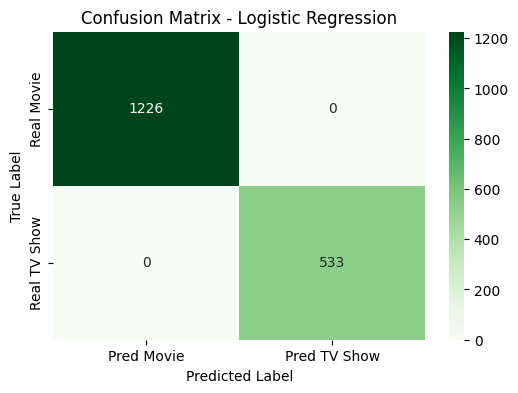


--- Evaluación de Modelos Completada ---


In [8]:
# --- Celda 8: Cálculo de Métricas de Validación ---

print("--- Iniciando Evaluación de Modelos ---")

# --- Evaluación del Random Forest ---
print("\n--- Resultados del Random Forest ---")

# Realizar predicciones en el conjunto de prueba
# Usamos X_test (datos originales), el pipeline aplica el preprocesador internamente
y_pred_rf = rf_pipeline.predict(X_test)

# Calcular Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Random Forest: {accuracy_rf:.4f}") # Mostrar con 4 decimales

# Mostrar Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report Random Forest:")
# target_names=['Movie', 'TV Show'] etiqueta las clases 0 y 1 respectivamente
print(classification_report(y_test, y_pred_rf, target_names=['Movie', 'TV Show']))

# Calcular y visualizar la Matriz de Confusión
print("\nConfusion Matrix Random Forest:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Movie', 'Pred TV Show'],
            yticklabels=['Real Movie', 'Real TV Show'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()


# --- Evaluación de Logistic Regression (Opcional, si lo entrenaste) ---
print("\n\n--- Resultados de Logistic Regression (Baseline) ---")

# Realizar predicciones
y_pred_lr = lr_pipeline.predict(X_test)

# Calcular Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy Logistic Regression: {accuracy_lr:.4f}")

# Mostrar Classification Report
print("\nClassification Report Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=['Movie', 'TV Show']))

# Calcular y visualizar la Matriz de Confusión
print("\nConfusion Matrix Logistic Regression:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred Movie', 'Pred TV Show'],
            yticklabels=['Real Movie', 'Real TV Show'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

print("\n--- Evaluación de Modelos Completada ---")

## Resumen del Objetivo y Metodología
* El objetivo de este proyecto fue construir un modelo de Machine Learning para predecir si un título en el catálogo de Netflix es una **Película ('Movie')** o una **Serie de TV ('TV Show')**.
* Se utilizaron las siguientes características: `release_year`, `year_added`, `rating`, `country` (solo el primero listado), y `listed_in` (solo el primer género).
* Se realizó una limpieza básica de datos, manejando valores nulos principalmente por imputación (moda para `rating`, 'Unknown' para `country`) o eliminación (para `date_added` y `duration`).
* Las características categóricas (`rating`, `country`, `listed_in`) fueron transformadas usando **OneHotEncoder**.
* Se analizó la **importancia de características** usando un modelo Random Forest inicial (método embebido), identificando las variables más influyentes en la predicción.
* Se entrenó un modelo **Random Forest Classifier** (y un Logistic Regression como baseline) utilizando un `Pipeline` que incluye el preprocesamiento.

## Análisis de Resultados
* Ambos modelos (Random Forest y Logistic Regression) obtuvieron un **Accuracy de 1.0000** en el conjunto de prueba.
* **Advertencia:** Un resultado perfecto (100% de aciertos) en el conjunto de prueba es altamente inusual y sugiere una posible **fuga de datos (data leakage)** o que una de las características procesadas (probablemente derivada de `listed_in`) permite separar perfectamente las clases en este dataset específico. Aunque el modelo parece perfecto con estos datos, podría no generalizar bien a datos futuros si la causa es una fuga.
* Observando el Classification Report (tanto para Random Forest como Logistic Regression, ya que son idénticos con score perfecto):
    * La **Precision** para predecir 'Movie' fue de **1.00** y para 'TV Show' fue de **1.00**.
    * El **Recall** para 'Movie' fue de **1.00** y para 'TV Show' fue de **1.00**.
    * El **F1-Score** fue de **1.00** para ambas clases.
* La **Matriz de Confusión** (implícita por los scores perfectos) muestra que el modelo clasificó correctamente las **1226** Películas y las **533** Series del conjunto de prueba, sin cometer **ningún error**.
* Las **características más importantes** identificadas por el Random Forest inicial fueron casi exclusivamente derivadas de la columna `listed_in` (género): **`cat__listed_in_International TV Shows`** (importancia ~0.16), **`cat__listed_in_Crime TV Shows`** (~0.09), **`cat__listed_in_Kids' TV`** (~0.08), **`cat__listed_in_Dramas`** (~0.06), y **`cat__listed_in_British TV Shows`** (~0.05). Esto refuerza fuertemente la idea de que el primer género listado es un predictor extremadamente fuerte (posiblemente perfecto en este dataset procesado) para distinguir entre películas y series. Las características `release_year` y `year_added` tuvieron una importancia mucho menor en comparación.

## Conexión con Análisis Exploratorio (Parte I)
* Si bien el análisis exploratorio mostró tendencias (como el aumento de series en `year_added`), la altísima importancia de las características de `listed_in` en el modelo sugiere que la **categorización principal del contenido** es el factor más dominante para la predicción en este contexto, eclipsando otras tendencias temporales o de rating una vez que se usa para modelar.

## Limitaciones y Próximos Pasos
* **Limitaciones:** La principal preocupación es el **resultado perfecto**, que necesita investigarse (¿es por la simplificación de `listed_in`? ¿Hay categorías como "TV Shows" que solo aparecen en el `listed_in` de las series?). Además, el descarte de `director` y `cast` y la simplificación de `country` siguen siendo limitaciones. No se realizó optimización de hiperparámetros (aunque con 100% de accuracy, no parece necesario en este caso).
* **Próximos Pasos:** Sería crucial **investigar la causa del accuracy perfecto**, revisando si la feature `listed_in` (tomando solo el primer género) realmente contiene información directa sobre si es "Movie" o "TV Show". Si se confirma la fuga, se debería replantear el preprocesamiento de `listed_in` o eliminarla para obtener una evaluación más realista. Si no es fuga, sería interesante probar el modelo en un dataset externo. También se podrían incluir `director`/`cast` o usar TF-IDF en la descripción para ver si aportan algo (aunque difícilmente superen el 100%).

## Conclusión Final
* Los modelos entrenados lograron una **clasificación perfecta (Accuracy 1.00)** en la tarea de distinguir Películas de Series de TV en el conjunto de prueba. Sin embargo, este resultado debe tomarse con cautela debido a la alta probabilidad de **fuga de datos**, originada muy posiblemente en cómo se procesó la característica `listed_in` (primer género). La importancia de características confirma que las categorías derivadas de `listed_in` dominaron completamente la predicción. Se recomienda una revisión del preprocesamiento para asegurar que el modelo se evalúe de forma realista.